In [166]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report,confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
import numpy as np

In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

In [168]:
x=pd.read_csv("X.csv")
y=pd.read_csv("Y.csv")

In [169]:
rifX=x
rifY=y["RIF"]

In [170]:
rifX.shape

(3393, 222)

Concatenating features with labels

In [171]:
rifConcatenated=pd.concat([rifX,rifY],axis=1)

In [172]:
rifConcatenated.shape

(3393, 223)

Checking duplicate rows

In [173]:
rifConcatenated.duplicated().value_counts()

False    2779
True      614
dtype: int64

Dropping Duplicate rows

In [174]:
rifConcatenated=rifConcatenated.drop_duplicates()
rifConcatenated.shape

(2779, 223)

Count of invalid labeled rows (label with -1 are invalid rows)

In [175]:
(rifConcatenated["RIF"]==-1).value_counts()

False    2725
True       54
Name: RIF, dtype: int64

Rows with invalid labels

In [176]:
invalidRows=rifConcatenated[rifConcatenated["RIF"]==-1]

In [177]:
invalidRows.index

Int64Index([ 313,  320,  346,  360,  381,  395,  397,  398,  403,  808, 1373,
            1586, 1588, 1706, 1715, 1717, 1800, 1857, 1902, 1945, 2190, 2355,
            2383, 2429, 2630, 2899, 2932, 2935, 3078, 3099, 3100, 3103, 3106,
            3109, 3112, 3118, 3125, 3128, 3131, 3135, 3139, 3155, 3189, 3214,
            3221, 3229, 3235, 3240, 3241, 3242, 3246, 3258, 3259, 3261],
           dtype='int64')

Dropping invalid labeled rows 

In [178]:
rifFiltered=rifConcatenated.drop(invalidRows.index)
rifFiltered.shape

(2725, 223)

Splitting the data into X and Y

In [179]:
rifX=rifFiltered.iloc[:,0:222]
rifY=rifFiltered.iloc[:,[222]]

In [180]:
rifX=rifX.replace(-1,0)

In [181]:
type(rifX)

pandas.core.frame.DataFrame

In [182]:
type(rifY)

pandas.core.frame.DataFrame

In [183]:
# rifY=(rifY.values).reshape(-1,)

In [184]:
type(y)

pandas.core.frame.DataFrame

In [185]:
rifY.shape

(2725, 1)

finding imbalance

1    1456
0    1269
Name: RIF, dtype: int64


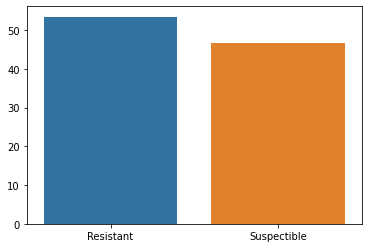

In [186]:
counts=rifFiltered['RIF'].value_counts()
print(counts)
proportions = counts / counts.sum()
proportions=proportions*100
sns.barplot(x=["Resistant","Suspectible"],y=proportions.values)
plt.show()

In [187]:
rifX_train,rifX_test,rifY_train,rifY_test=train_test_split(rifX,rifY,test_size=0.2,random_state=21)

In [188]:
rifX_train.shape

(2180, 222)

## Feature Selection

Information gain

In [189]:
from sklearn.feature_selection import mutual_info_classif
information_gain_scores=mutual_info_classif(rifX_train,rifY_train)
information_gain_best_features_indices= information_gain_scores.argsort()[::-1][0:128]
infomation_gain_train=rifX_train.iloc[:,information_gain_best_features_indices]
infomation_gain_test=rifX_test.iloc[:,information_gain_best_features_indices]

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [190]:
np.unique(rifX.values,return_counts=True)

(array([0, 1], dtype=int64), array([548942,  56008], dtype=int64))

Chi square

In [214]:
from sklearn.feature_selection import SelectKBest,chi2
selector=SelectKBest(chi2,k=64)
chi_square_selected_features=selector.fit_transform(rifX_train,rifY_train)
chi_square_selected_features.shape
np.unique(selector.get_support(),return_counts=True)
print(selector.get_support())
rifX_train.iloc[:,selector.get_support()].shape

[False False False False False False False  True  True  True False False
 False False False False False False False  True False False  True False
 False  True False False False  True False  True  True False False False
 False  True False  True False False False False False  True False False
  True False False False False False  True  True False  True  True  True
 False False False False False False False False False False  True  True
  True  True  True False  True False False False  True False False False
 False False False False False  True  True False False False False False
  True False False False  True False False False False False False False
 False False False False False  True False  True False  True False False
 False False  True False False False False  True False False  True  True
 False False  True False False False False False  True False  True False
 False  True False False False False  True False False False  True False
  True False False False  True False False False  T

(2180, 64)

Auto encoders

In [192]:
import math,numpy as np

In [193]:
input_data = Input(shape=(222,))
encoded = Dense(64, activation='relu')(input_data)
encoder = Model(input_data, encoded)
auto_enconder_data_train = encoder.predict(rifX_train)

69/69 [==============================] - 0s 3ms/step


In [194]:
input_data_t = Input(shape=(222,))
encoded_t = Dense(64, activation='relu')(input_data_t)
encoder_t = Model(input_data_t, encoded_t)
auto_enconder_data_test = encoder_t.predict(rifX_test)

18/18 [==============================] - 0s 1ms/step


parameter tuning for random forest

In [195]:
model1=RandomForestClassifier()
param_grid = {
    'n_estimators': [30,50, 100],
    'max_depth': [None, 5, 10],
}
grid_search = GridSearchCV(model1, param_grid=param_grid, cv=5, n_jobs=-1,scoring='roc_auc',verbose=0)
grid_search.fit(rifX, rifY)
print(grid_search.best_params_)

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 5, 'n_estimators': 100}


parameter tuning for svm

In [196]:
model2=svm.SVC()
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(model2, param_grid, refit=True, verbose=0, cv=5,scoring='roc_auc')
grid_search.fit(rifX, rifY)
print(grid_search.best_params_)

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}


parameter tuning for logistic regression

In [ ]:
# model3=LogisticRegression()
# param_grid = {'C': [ 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
# grid_search = GridSearchCV(model3, param_grid=param_grid,cv=5,verbose=0)
# grid_search.fit(rifX, rifY)
# print(grid_search.best_params_)

# parameter tuning for BernoulliNB

In [ ]:
model4=BernoulliNB()
param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(model4, param_grid=param_grid, cv=5,scoring='roc_auc',verbose=0)
grid_search.fit(rifX, rifY)
print("Best hyperparameters:", grid_search.best_params_)

# model1 (random forest)

C:\Users\chandra sekhar\AppData\Local\Temp\ipykernel_20396\3326331175.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rifModel1.fit(rifX_train,rifY_train)


Random forest
--------------------
accuracy  0.8990825688073395
f1_score  0.9056603773584906
auc  0.9025857131167662
precision  0.9428571428571428
sensitivity  0.8712871287128713
specificity  0.12871287128712872


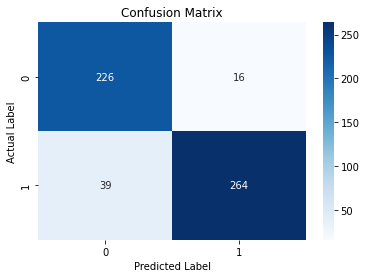

In [197]:
rifModel1=RandomForestClassifier(n_estimators=50,max_depth=5)
rifModel1.fit(rifX_train,rifY_train)
rifPred=rifModel1.predict(rifX_test)
print("Random forest")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Random Forest with Reduced_Features

C:\Users\chandra sekhar\AppData\Local\Temp\ipykernel_20396\3449771269.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rifModel1.fit(auto_enconder_data_train,rifY_train)


Random forest
--------------------
accuracy  0.618348623853211
f1_score  0.7078651685393259
auc  0.5914614188691596
precision  0.6161369193154034
sensitivity  0.8316831683168316
specificity  0.16831683168316836


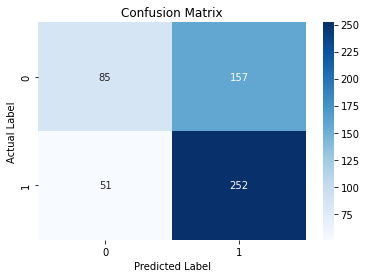

In [198]:
rifModel1=RandomForestClassifier(n_estimators=50,max_depth=5)
rifModel1.fit(auto_enconder_data_train,rifY_train)
rifPred=rifModel1.predict(auto_enconder_data_test)
print("Random forest")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# model 2 (svm)

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM
--------------------
accuracy  0.9596330275229358
f1_score  0.9639344262295082
auc  0.9582890107192537
precision  0.9576547231270358
sensitivity  0.9702970297029703
specificity  0.02970297029702973


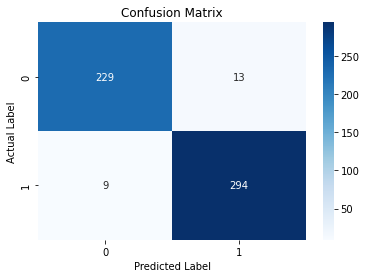

In [199]:
rifModel2=svm.SVC(kernel="linear",C= 0.1, gamma= 0.1)
rifModel2.fit(rifX_train,rifY_train)
rifPred=rifModel2.predict(rifX_test)
print("SVM")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

SVM with Reduced_Data

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM
--------------------
accuracy  0.6256880733944954
f1_score  0.7417721518987341
auc  0.5826719035539918
precision  0.6016427104722792
sensitivity  0.966996699669967
specificity  0.03300330033003296


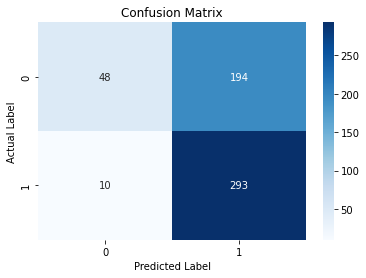

In [200]:
rifModel2=svm.SVC(kernel="linear",C= 0.1, gamma= 0.1)
rifModel2.fit(auto_enconder_data_train,rifY_train)
rifPred=rifModel2.predict(auto_enconder_data_test)
print("SVM")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

svm with infomation gain features

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM
--------------------
accuracy  0.9522935779816514
f1_score  0.9570957095709571
auc  0.9516883506532471
precision  0.9570957095709571
sensitivity  0.9570957095709571
specificity  0.04290429042904287


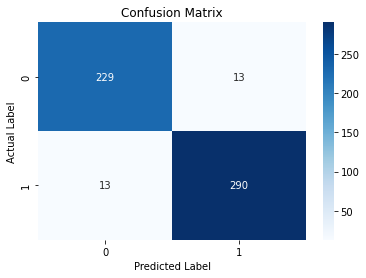

In [201]:
rifModel2=svm.SVC(kernel="linear",C= 0.1, gamma= 0.1)
rifModel2.fit(infomation_gain_train,rifY_train)
rifPred=rifModel2.predict(infomation_gain_test)
print("SVM")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# model 3 (Logistic regression)

c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression
--------------------
accuracy  0.9596330275229358
f1_score  0.9638157894736842
auc  0.9587049614052314
precision  0.9606557377049181
sensitivity  0.966996699669967
specificity  0.03300330033003296


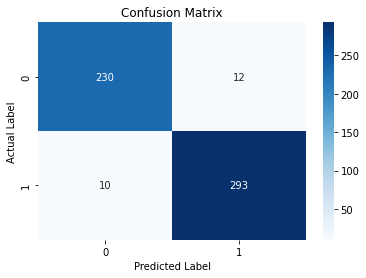

In [202]:
rifModel3=LogisticRegression()
rifModel3.fit(rifX_train,rifY_train)
rifPred=rifModel3.predict(rifX_test)
print("Logistic Regression")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# model4 (bernoulliNB)


c:\Users\chandra sekhar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB
--------------------
accuracy  0.8935779816513761
f1_score  0.9010238907849829
auc  0.8963873660093281
precision  0.9328621908127208
sensitivity  0.8712871287128713
specificity  0.12871287128712872


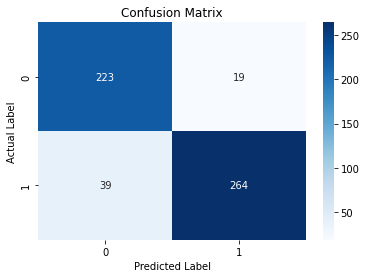

In [203]:
rifModel4=BernoulliNB(alpha=10)
rifModel4.fit(rifX_train,rifY_train)
rifPred=rifModel4.predict(rifX_test)
print("BernoulliNB")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(rifX, rifY, test_size=0.2, random_state=22)
def nnModel(optimizer):
    model = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.4),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
keras_classfier=KerasClassifier(build_fn=nnModel,verbose=0)
param_grid={
    "batch_size":[16,32],
    "epochs":[5,10,15],
    "optimizer":["adam","adagrad","rmsprop","sgd"]
}

grid_search=GridSearchCV(estimator=keras_classfier,param_grid=param_grid,cv=5)
grid_search.fit(X_train,Y_train)
grid_search.best_params_
grid_search.best_params_
y_pred = grid_search.predict(X_test)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions

# Calculate accuracy
# accuracy = accuracy_score(Y_test, y_pred_binary)
print("Neural Networks")
print("--------------------")
print("accuracy ", accuracy_score(Y_test,y_pred_binary))
print("f1_score ", f1_score(Y_test,y_pred_binary))
print("auc ", roc_auc_score(Y_test,y_pred_binary))
print("precision ",precision_score(Y_test,y_pred_binary))
print("sensitivity ",recall_score(Y_test,y_pred_binary))
print("specificity ",1-recall_score(Y_test,y_pred_binary))
# print(f"Test accuracy: {accuracy:.2f}")

C:\Users\chandra sekhar\AppData\Local\Temp\ipykernel_11268\1408214298.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classfier=KerasClassifier(build_fn=nnModel,verbose=0)


18/18 [==============================] - 0s 1ms/step
Neural Networks
--------------------
accuracy  0.9522935779816514
f1_score  0.9547038327526133
auc  0.9515950705174877
precision  0.9383561643835616
sensitivity  0.9716312056737588
specificity  0.028368794326241176


# evaluating using cross_validation_score with folds=30

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
print("Random Forest")
aucScores=cross_val_score(rifModel1, rifX, rifY, cv=30, scoring="roc_auc")
f1Scores = cross_val_score(rifModel1, rifX, rifY, cv=30, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())

Random Forest


Mean f1_score  0.8391460722804006
Mean auc  0.9880844715147041


In [ ]:
print("SVM")
aucScores=cross_val_score(rifModel2, rifX, rifY, cv=30, scoring="roc_auc")
f1Scores = cross_val_score(rifModel2, rifX, rifY, cv=30, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())

SVM
Mean f1_score  0.950599159141003
Mean auc  0.9907547325870179


In [ ]:
print("Logistic Regression")
aucScores=cross_val_score(rifModel3, rifX, rifY, cv=20, scoring="roc_auc")
f1Scores = cross_val_score(rifModel3, rifX, rifY, cv=20, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())
# print(aucScores)

Logistic Regression
Mean f1_score  0.9366939164996181
Mean auc  0.9902883099586866


In [ ]:
print("BernoulliNB")
aucScores=cross_val_score(rifModel4, rifX, rifY, cv=30, scoring="roc_auc")
f1Scores = cross_val_score(rifModel4, rifX, rifY, cv=30, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())
# print(aucScores)

BernoulliNB
Mean f1_score  0.8369039315330876
Mean auc  0.9596326288913498
